# RAPIDS analysis of single-cell ATAC-seq data from 60K cells

Copyright (c) 2020, NVIDIA CORPORATION.
Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

The dataset we use here comes from [Lareau et al., Nat Biotech 2019](https://www.nature.com/articles/s41587-019-0147-6), one of the highest throughput single-cell ATAC-seq experiments to date. They assay 136K resting and stimulated bone marrow-derived cells and study the different cell types and lineages that emerge. The paper analyzes resting & stimulated cells separately (and we also find that these two populations split into largely distinct clusters), so here we only focus on the 60K resting cells from this experiment.

The cell metadata from this experiment includes annotated putative cell types based on chromVAR, Louvain clustering, and downstream cluster analysis. We compare our de novo identified clusters to these annotated clusters from the paper (and find good agreement).

The peak-cell matrix along with peak and cell metadata files are publicly available on GEO, [GSE123580](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE123580).

### Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata 
import matplotlib.pyplot as plt
from collections import OrderedDict

import time
import os, wget

import cudf
import cupy as cp

from cuml.decomposition import PCA
from cuml.manifold import TSNE

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

In [2]:
import rmm

rmm.reinitialize(
    managed_memory=True, # Allows oversubscription
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)

cp.cuda.set_allocator(rmm.allocators.cupy.rmm_cupy_allocator)

## Input data

In the cell below, we provide the path to the sparse .h5ad file containing the peak x cell count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

In [3]:
%%time
adata = anndata.read_h5ad('../../BrCa/session_file_harmony.h5ad')
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']
print(adata)

AnnData object with n_obs × n_vars = 1845429 × 60
    obs: 'imagecol', 'imagerow', 'batch', 'leiden'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'batch_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
CPU times: user 996 ms, sys: 1.57 s, total: 2.57 s
Wall time: 5.26 s


## Cluster & Visualize

### UMAP visualization

In [4]:
%%time
n_neighbors = 30
knn_n_pcs = 50
# sc.pp.neighbors(adata, n_neighbors=n_neighbors,n_pcs=knn_n_pcs, method='umap', use_rep='X_pca')
sc.pp.neighbors(adata, n_neighbors=n_neighbors,n_pcs=knn_n_pcs, method='rapids', use_rep='X_pca')

CPU times: user 2min 5s, sys: 4.1 s, total: 2min 9s
Wall time: 2min


In [5]:
%%time
umap_min_dist = 0.3 
umap_spread = 1.0
# sc.tl.umap(adata, method='umap')
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

CPU times: user 1min 39s, sys: 804 ms, total: 1min 40s
Wall time: 1min 40s


### Graph clustering

Below, we show how to use the RAPIDS Louvain clustering or Leiden clustering functions to cluster the data.

In [6]:
%%time
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata, resolution=0.5)

CPU times: user 1min 48s, sys: 25.7 s, total: 2min 14s
Wall time: 2min 14s


In [12]:
%%time
# sc.tl.louvain(adata)
sc.tl.louvain(adata, flavor='rapids', resolution=0.5)

CPU times: user 2min 40s, sys: 41.6 s, total: 3min 22s
Wall time: 3min 21s


Below, we plot the UMAP visualization of the cells colored by the Louvain clusters. Next, we color the cells using the cell type annotations reported in the source paper. We see that the clusters we discovered match closely with the reported cell types.

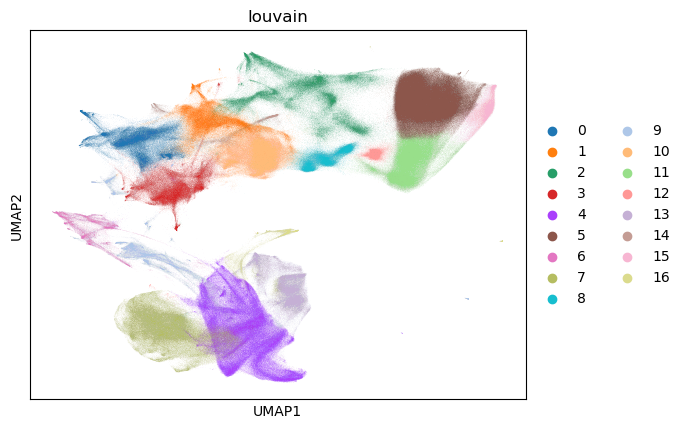

CPU times: user 4.42 s, sys: 231 ms, total: 4.65 s
Wall time: 4.42 s


In [19]:
%%time
# fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 12), dpi=100)

sc.pl.umap(adata, color=['louvain'], cmap='viridis', show=False)
# sc.pl.umap(adata, color=['louvain'], ax=axs[0], show=False)
# sc.pl.umap(adata, color=['leiden'], ax=axs[1], show=False)

# plt.tight_layout()
plt.show()

In [18]:
del adata.uns['louvain_colors']
print(adata)

AnnData object with n_obs × n_vars = 1845429 × 60
    obs: 'imagecol', 'imagerow', 'batch', 'leiden', 'louvain'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'batch_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap', 'louvain'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
